# CSC413 Lab 4: Differential Privacy

In this lab, we will explore how training a neural network with
some of the optimization methods discussed in the lecture
can cause models to capture more information about the training
data than we might intend.
We will discuss why this may be problematic from a privacy perspective,
and introduce the idea of **differential privacy**.

Finally, this lab introduces an optimization strategy called
**DP-SGD** or differentially private stochastic gradient descent.
This strategy has some provable properties about the amount of information
captured.

This lab also serves as an introductory guide to implementing optimization
models that are presented in research papers. We hope that the techniques
used in this lab build skills so that you can implement new techniques and ideas
presented in other papers.

By the end of this lab, you will be able to:

1. Recognize that typical methods of using SGD to train a neural network might capture too much information about the training data.
2. Articulate the importance of privacy to stakeholders.
3. Explain the components of the DP-SGD algorithm.
4. Compare models trained using SGD and those trained with DP-SGD through the lens of differential privacy.
5. Implement, from an algorithm description, optimization techniques like DP-SGD that requires manual gradient manipulation in Pytorch.

Please work in groups of 1-2 during the lab.

Acknowledgements:

- The MedMNIST data is from https://medmnist.com/
- This assignment is written by Mahdi Haghifam, Sonya Allin, Lisa Zhang, Mike Pawliuk and Rutwa Engineer

Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Make sure to run a final version of your notebook prior to submission.
Then "Export the notebook as PDF" using the menu on the top left of your screen (assuming a standard browser setup).

Submit the generated PDF file `lab04.pdf` on Markus
**containing all your solutions to the Graded Task**s.
Your file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

1. Part 2: Description of the difference between the non-dp model predictions over data in/out of training (1 point)
2. Part 3: Explanation of why the "average height" model is not $\epsilon$-DP (1 point)
3. Part 4: Explanation of `T_max` in `CosineAnnealingLR` (1 point)
4. Part 4: Explanation why `max_grad_norm >= 7.49` causes gradient clipping to remain unchanged in the example (1 point)
5. Part 4: Implementation of `dp_grads` function (4 points)
6. Part 4: Explanation of the difference in the histogram of the dp and non-dp models (1 point)
7. Part 4: Analysis of the impact of privacy breach on a vulnerable individual (1 point)

## Google Colab Setup

Like last week, we will be using the `medmnist` data set, which is available as a Python package.
We will also be using `opacus`, which is a differential privacy library.

Recall that on Google Colab, we use "!" to run shell commands.
Below, we use such commands to install the Python packages.

In [ ]:
!pip install medmnist
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=6a7798e9e0c742eadbaba30b51af319f61324c8e8aa68787da6805c7287aa4f5
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 4.4 MB/s eta 0:00:00


## Part 1. Data and Model

We will be using the same data and model as in lab 3, with modifications in the way that the
training, validation, and test sets are split. These modifications are necessary to be able to
showcase differential privacy issues using a small model and limited data set size to ensure
that models do not take an overwhelming amount of time to train.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import opacus
import medmnist
from medmnist import PneumoniaMNIST
import torchvision.transforms as transforms

import torch.utils.data as data_utils

medmnist.INFO['pneumoniamnist']


{'python_class': 'PneumoniaMNIST',
 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1',
 'MD5': '28209eda62fecd6e6a2d98b1501bb15f',
 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1',
 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6',
 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1',
 'MD5_128': '05b46931834c231683c68f40c47b2971',
 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1',
 'MD5_224': 'd6a3c71de1b94

**Task** Use code from lab 3 to re-acquaint yourself with the training data.
What do the inputs look like? What about the targets? What is the distribution
of the targets? Intuitively, how difficult is the classification problem?

In [ ]:
# The classification problem is difficult as the distribution of data makes it
# so that a constant classifier could have 75% accuracy, a good model needs to
# be much higher than 75% success. This is because 75% of the training data
# is skewed towards one of the classes, so both cases are not represented
# equally.

**Task**: Using the standard train/validation/test split provided
by the dataset, what percentage of the training set had the label `0`?
What about the validation set?

In [ ]:
train_imgs = PneumoniaMNIST(split='train', download=True)
valid_imgs = PneumoniaMNIST(split='val', download=True)
num_train = 0
num_val = 0
for img, target in train_imgs:
    if target == 0:
      num_train += 1

for img, target in valid_imgs:
    if target == 0:
      num_val += 1
print(num_train/4708,num_val/524)
# About 25% of the data is 0 in both training and validation.

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
0.2578589634664401 0.25763358778625955


These statistics differ significantly between the training, validation
and test sets for our DP demonstration to work well with our small MLP model.
Thus, we will perform our own split of the training, validation, and test sets.

In addition, we will split the data into four sets: training, validation,
test, and a **memorization assessment set**.
This data set will be the same size as our training set.
Practitioners sometimes call this set a *second* or *unused* training set,
even though this data set is not used for training.
The idea is that we want to see if there is a difference between
data that we actually used for training, vs another data that we *could have*
used for training.

**Task**: Run the following code to obtain the four datasets.

In [ ]:
# Load the training, validation, and test sets
# We will normalize each data set to mean 0.5 and std 0.5: this
# improves training speed
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])
train_dataset = PneumoniaMNIST(split='train', transform=data_transform, download=True)
valid_dataset = PneumoniaMNIST(split='val', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True)

# Combine the training and validation
combined_data = train_dataset + valid_dataset

# Re-split the data into training,  memory assessment
train_dataset, mem_asses_dataset, valid_dataset = torch.utils.data.random_split(combined_data, [0.4, 0.4, 0.2])

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


**Task**: What percentage of the training set had the label `0`?
What about the memorization assessment set?
What about the validation set?

In [ ]:
# About 25% of training is 0, and 6% of the mem. ass. is 0.
num_train = 0
num_asses = 0
for img, target in train_dataset:
    if target == 0:
      num_train += 1

for img, target in mem_asses_dataset:
    if target == 0:
      num_asses += 1
print(num_train/len(train_dataset),num_val/len(mem_asses_dataset))

0.25322503583373146 0.06450071667462971


Now that our data is ready, we can set up the model and training code similar to lab 3.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPModel(nn.Module):
    """A three-layer MLP model for binary classification"""
    def __init__(self, input_dim=28*28, num_hidden=600):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        return out

To explore the distribution of predicted logits,
the following code is written for you:
it produces both the predictions and ground-truth labels across a dataset.
There is also another utility function that can be used to measure the accuracy.

In [ ]:
def get_predictions(model, data):
    """
    Return the ground truth and predicted value across a dataset.
    Unlike the get_prediction function in lab 3, this dataset
    will produce the predictions for the *entire* dataset (no sampling)

    Parameters:
        `model` - A PyTorch model
        `data` - A PyTorch dataset of MedMNIST images

    Returns: A tuple `(ys, ts)` where:
        `ys` is a list of prediction probabilities, same length as `data`
        `ts` is a list of ground-truth labels, same length as `data`
    """
    ys, ts = [], []
    loader = torch.utils.data.DataLoader(data, batch_size=100)
    for X, t in loader:
        z = model(X.reshape(-1, 784))
        ys += [float(y) for y in torch.sigmoid(z)]
        ts += [float(t_) for t_ in t]
    return ys, ts

def accuracy(model, dataset):
    """
    Compute the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model` - A PyTorch model
        `dataset` - A PyTorch dataset of MedMNIST images

    Returns: a floating-point value between 0 and 1.
    """

    ys, ts = get_predictions(model, dataset)
    predicted = np.ndarray.round(np.array(ys))
    return np.mean(predicted == ts)

The training code below is analogues to the training code used in lab 3,
with some differences.
One difference is that we use the **Adam** optimizer rather than SGD.
The Adam optimizer combines ideas from momentum and RMSProp and is able
to train our model to a suitable accuracy with much fewer iterations.

**Task**: Run the code below to train our (non-private) model.

20 Loss: 0.38329705595970154 Train Acc: 0.8948877209746775 Val Acc: 0.887189292543021
40 Loss: 0.177164688706398 Train Acc: 0.9483994266602962 Val Acc: 0.9302103250478011
60 Loss: 0.19379732012748718 Train Acc: 0.9565217391304348 Val Acc: 0.9388145315487572
80 Loss: 0.17520633339881897 Train Acc: 0.9603440038222647 Val Acc: 0.9388145315487572
100 Loss: 0.05391472950577736 Train Acc: 0.9698996655518395 Val Acc: 0.9359464627151052
120 Loss: 0.06047148257493973 Train Acc: 0.9698996655518395 Val Acc: 0.9426386233269598
140 Loss: 0.08988001942634583 Train Acc: 0.9722885809842332 Val Acc: 0.9349904397705545
160 Loss: 0.048120416700839996 Train Acc: 0.9765886287625418 Val Acc: 0.9445506692160612
180 Loss: 0.0393424816429615 Train Acc: 0.9789775441949355 Val Acc: 0.9426386233269598
200 Loss: 0.11517095565795898 Train Acc: 0.9856665074056379 Val Acc: 0.9435946462715105
220 Loss: 0.0499066598713398 Train Acc: 0.985188724319159 Val Acc: 0.9493307839388145
240 Loss: 0.0714024156332016 Train Acc: 0

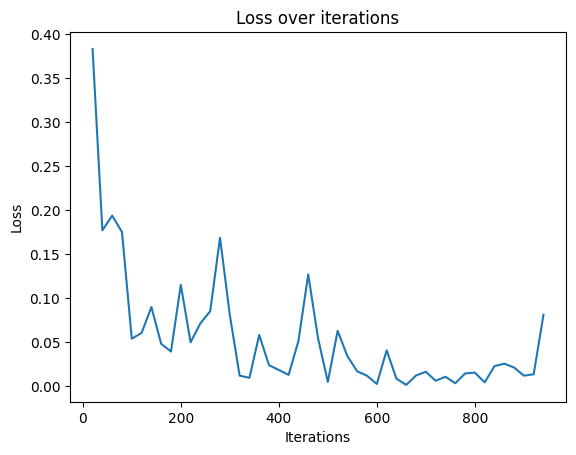

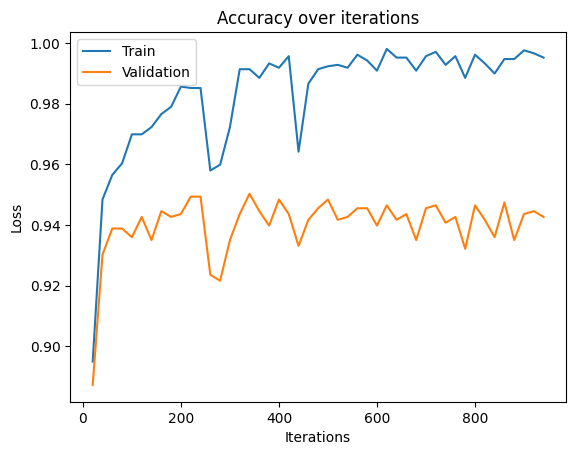

In [ ]:
def train_model(model,                # a PyTorch model
                train_data,           # training data
                val_data,             # validation data
                learning_rate=1e-2,
                batch_size=100,
                num_epochs=45,
                plot_every=20,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    for e in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
              z = model(images.reshape(-1, 784))
              loss = criterion(z, labels.to(torch.float))
              loss.backward()
              optimizer.step()
              optimizer.zero_grad()

              iter_count += 1
              if iter_count % plot_every == 0:
                  iters.append(iter_count)
                  ta = accuracy(model, train_data)
                  va = accuracy(model, val_data)
                  train_loss.append(float(loss))
                  train_acc.append(ta)
                  val_acc.append(va)
                  print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)

    if plot:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend(["Train", "Validation"])

model_np = MLPModel()
train_model(model_np, train_dataset, valid_dataset)

## Part 2. Privacy issues in our model

In this part of the lab, we will show that our trained model captures
more information about the training data than we might intend. In particular,
we show that the model predictions have different patterns for images used in
training (compared to images that are not used in training).
Specifically, the prediction logits follow a different distribution for
training images and images not used for training.

In more general applications, the patterns in the logit distributions can be used
to build classifiers that can predict **whether an image was used in training**
a neural network.

**Task**: Suppose that you are a patient in a medical study, who consented
for their data to be used to train a machine learning model to detect the strains
of certain diseases (i.e., strain A or B of the same disease).
Explain why you might *not* want it be known that your data was used to build the
model.

In [ ]:
# If the model is not fully private in how your data modified it, knowledge of
# your data could lead to being able to find some sensitive private medical
# information in the model. This would include possible knowledge of your
# condition and so on. This is clearly a privacy concern, as this data could
# be mishandled or misused if it is accessible by the broad public or by few
# highly trained data extraction experts.

Recall that we used `train_dataset` to train our model,
but did not use the `mem_asses_dataset`. To show that our model behaves differently
for data used in training (vs not), we will plot the histogram of prediction
probabilities across these two datasets.

**Task**: Run the code below, which produces *cumulative* histogram plots showing
showing the *log* model predictions of negative and positive samples (truth label=0 vs
true label=1). The predictions for data point in the training set is shown in blue.
The predictions for data points *not* in the training set (in the memorization assessment set)
is in red.

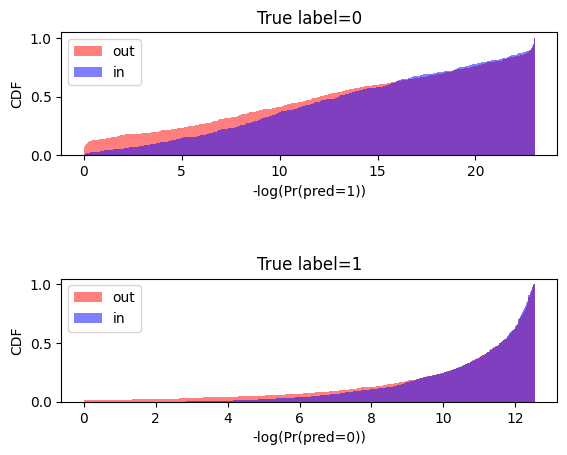

In [ ]:
def plot_hist(model, in_dataset, out_dataset):
    """
    Plots the histogram (cumulative, in the log space) of the predicted
    probabilities for datasets that is in the training set vs out. The
    histograms are separated by the true labels.

    Parameters:
        `model` - A PyTorch model
        `in_dataset` - A PyTorch dataset used for training
                       (i.e. *in* the training set)
        `out_dataset` - A PyTorch dataset not used for training
                       (i.e. *out* the training set)
    """
    # Obtain the prediction for data points in both data sets
    ys_in, ts_in  = get_predictions(model, in_dataset)
    ys_out, ts_out = get_predictions(model, out_dataset)

    # Compute the negative log() of these predictions, separated by the
    # ground truth labels. An epsilon is added to the prediction for
    # numerical stability
    epsilon = 1e-10
    conf_in_0 = [-np.log(y + epsilon) for t, y in zip(ts_in, ys_in) if t == 0]
    conf_in_1 = [-np.log(1 - y + epsilon) for t, y in zip(ts_in, ys_in) if t == 1]
    conf_out_0 = [-np.log(y + epsilon) for t, y in zip(ts_out, ys_out) if t == 0]
    conf_out_1 = [-np.log(1 - y + epsilon) for t, y in zip(ts_out, ys_out) if t == 1]

    # Bins used for the density/histogram
    bins_0 = np.linspace(0,max(max(conf_in_0),max(conf_out_0)),500)
    bins_1 = np.linspace(0,max(max(conf_in_1),max(conf_out_1)),500)

    # Plot the histogram for the predicted probabilities for true label = 0
    plt.subplot(2, 1, 1)
    plt.hist(conf_out_0, bins_0, color='r', label='out', alpha=0.5,cumulative=True, density=True)
    plt.hist(conf_in_0, bins_0, color='b', label='in', alpha=0.5,cumulative=True, density=True)
    plt.legend()
    plt.ylabel('CDF')
    plt.xlabel('-log(Pr(pred=1))')
    plt.title("True label=0")

    # Plot the histogram for the predicted probabilities for true label = 1
    plt.subplot(2, 1, 2)
    plt.hist(conf_out_1, bins_1, color='r', label='out', alpha=0.5,cumulative=True, density=True)
    plt.hist(conf_in_1, bins_1, color='b', label='in', alpha=0.5,cumulative=True, density=True)
    plt.legend()
    plt.title("True label=1")
    plt.ylabel('CDF')
    plt.xlabel('-log(Pr(pred=0))')

    plt.subplots_adjust(hspace=1)
    plt.show()

plot_hist(model_np, train_dataset, mem_asses_dataset)
plt.close()

**Graded Task**: What difference do you notice between the histograms of the
data points *in* the training set, vs those *not in* the training set?
Explain how this difference is indicative of *overfitting*.

In [ ]:
# Since the histograms show the negative log probability of the opposite label
# prediction, we want it to be concentrated at larger values since we want less
# values to have low negative log probabilities, which indicate a close to 1
# probability of the opposite label to the true label.

# THis is reflected decently in both the training and assessment histogram
# predictions, as most of the data is concentrated at the peak on the right side
# but comparatively, we can see that the assessment data has a small piece
# bulging out on the left side above the training, so it seems to have more
# fraction of incorrect predictions than on the training, which suggests that
# the model overfitted to the training data, since it does so well on training
# but seems to get wrong a larger portion of the data from assessment, although
# still decently predicting.

## Part 3. Differential Privacy

In the previous section, we observed that a model's prediction confidence for
the samples inside its training set can be different from those outside the
training set.
We already know that this disparity has a negative impact on the model's
performance during test time. This phenomenon is known as overfitting and
we know several techniques on how to measure and reduce the overfitting.
In this part, we want to argue that this disparity has a negative impact on
**privacy** of the training samples.

Assume the designed model in the previous section is published for the public as
a classification model for Pneumonia.  Assume that the training set consists of
individuals' X-ray. Even though the participants have consented to participate
in the research, their privacy should still be protected. If an attacker can
determine whether a specific individual's data is part of the research dataset,
it might lead to unintended privacy breaches. Participants might not want their
involvement in such a study to be public knowledge due to the stigma associated
with certain medical conditions. This disparity may also help an attacker to
reconstruct a participant's data. This example shows that the disparity between
the model's confidence lets the adversary infer the membership of a sample from
the predictions. This is alarming! In the next part, we discuss how to mitigate
this risk by introducing the fundamental concept of **Differential Privacy**.

Differential privacy (DP) is a data privacy framework that aims to provide strong
privacy guarantees when analyzing or sharing sensitive data.
**We say an ML algorithm satisfies Differential Privacy if changing *one* of the
training samples does not change the output of the algorithm *significantly*.**
DP is an interesting property: assume you want to give a hospital access to your X-ray. If the hospital uses a DP ML algorithm, then, you are guaranteed that your presence does not affect the output significantly. This is promising and motivates people to give access to their data for the purpose of data analysis.

Next, we discuss how to formalize DP.

Assume we have a dataset $S=\{(x_1,y_1),\dots,(x_n,y_n)\}$
which consists of $n$ individuals data. Consider the neighboring dataset
$S'=\{(x_1,y_1),\dots,(x'_n, y'_n)\}$
which differs from $S$ in only one sample. Then, we say a randomized algorithm $\mathcal{A}$ satisfies $\epsilon$-DP if for all the output $y$ in the range of $\mathcal{A}$ it satisfies

$$
\mathbb{Pr}\left(\mathcal{A}(S) =y \right) \leq \exp(\epsilon)  \mathbb{Pr}\left(\mathcal{A}(S’) =y \right).
$$

But what is the intuition behind this equation?

$\epsilon$  is called the privacy budget. Privacy budget captures how strong our privacy guarantees are, by showing that the outcome is indistinguishable in two neighboring datasets. This can be shown by setting  $\epsilon = 0$, the probability the analysis having an outcome is the same with or without you in the database. So if we set  $\epsilon$ to some small value, we can get good guarantees that the output will not differ much.

A common property of privacy-preserving algorithms is randomness. To see why it is the case assume we are interested in the average height of the students enrolled in
CSC413while preserving their privacy. Consider a **deterministic** algorithm that reports the average height of the students. We argue that there exists no finite $\epsilon$ for which this algorithm is DP.  For this example, it can be shown that by adding a Gaussian noise to the average height we can preserve privacy of the individuals.

**Graded Task**: Explain why the algorithm that reports the average height of the students is not $\epsilon$-DP for any finite $\epsilon>0$.

In [ ]:
# Changing the height of a single student (replacing them) while fixing all the
# others will always change the prediction of the average height, since the
# average is linear and bijective in each argument while leaving the others
# fixed. Because the probability of this deterministic prediction follows a
# Discrete distribution with probability 1 only at the exact average, the
# probability is guaranteed to change to 0 for the same desired average value
# if we adjust the sample by one student.

# Intuitively, without any randomness, each sample will have a precise effect
# on the average, and so it will always remain sensitive to individual samples.
# The reason why adding a perturbative noise to the samples will make it more
# likely to be e-DP is because the probability of the adjusted sample being the
# same value is no longer 0 since it no longer follows a discrete single point
# distribution (non-deterministic).

We hope that the basic intuition behind differential privacy is now clear. DP is now a widely-used method to preserve privacy. It has been used in companies like Google and Apple to gather the user’s data. It is also recently used for the US Census. See the following [video]{https://www.youtube.com/watch?v=nVPE1dbA394} to get more information.

## Part 4. Differentially-Private SGD

In this section, we discuss how we can make stochastic gradient descent differentially private and implement it.
We will follow the algorithmic description of DP-SGD forom [https://arxiv.org/pdf/1607.00133.pdf](https://arxiv.org/pdf/1607.00133.pdf)
that we reproduce below. Start by reading the words/headings in the description, then we will discuss
the algorithm line by line.

Algorithm Outline for Differentially Private SGD (DP-SGD)

**Input** Examples $\left\{x_1, \ldots, x_N\right\}$, loss function $\mathcal{L}(\theta)=$
$\frac{1}{N} \sum_i \mathcal{L}\left(\theta, x_i\right)$.

**Parameters**: learning rate $\eta_t$, noise scale, $\sigma$, group size $L$, gradient norm bound $C$. \\

**Initialize** $\theta_0$ randomly

**for**  $t \in[T]$ do
  * Take a random sample $L_t$ with sampling probability $L / N$
  * **Compute gradient** $\quad$ For each $i \in L_t$, compute $\mathbf{g}_t\left(x_i\right) \leftarrow \nabla_{\theta_t} \mathcal{L}\left(\theta_t, x_i\right)$
  * **Clip gradient** $\overline{\mathbf{g}}_t\left(x_i\right) \leftarrow \mathbf{g}_t\left(x_i\right) / \max \left(1, \frac{\left\|\mathbf{g}_t\left(x_i\right)\right\|_2}{C}\right)$
  * **Add noise** $\tilde{\mathbf{g}}_t \leftarrow \frac{1}{L}\left(\sum_i \overline{\mathbf{g}}_t\left(x_i\right)+\mathcal{N}\left(0, \sigma^2 C^2 \mathbf{I}\right)\right)$ \\
  * **Descent** $\theta_{t+1} \leftarrow \theta_t-\eta_t \tilde{\mathbf{g}}_t$

**Output** $\theta_T$ and compute the overall privacy cost $(\varepsilon, \delta)$ using a privacy accounting method.


**Task**: Read the algorithm above. Write down, for each symbol/notation used in the algorithm,
what it represents. Pay particular attention to the symbol $\mathbf{g}_t\left(x_i\right)$
and its various modifications.

In [ ]:
# L_t represents a random sample chosen uniformly for SGD with size L, which
# we then compute the gradient on the parameters theta_i for each element x_i,
# given by g_t(x_i). We then normalize the gradient to be under C, by dividing
# by its norm and then multiplying by some C if its larger than 1, and otherwise
# letting it be if it is already below 1.

# We then take the average gradient over L_t as usual, but instead also add
# some normalized noise with isotropic variance sigma*C to ensure that the
# noise does not dominate the gradient. We then perform the regular update
# rule with the learning rate eta_t.

Now, let's discuss the algorithm line by line.

- **Sampling**: The sampling mechanism used in DP-SGD is different from SGD.
  In non-private SGD, we choose a random permutation at the beginning of each epoch.
  However, in DP-SGD at each iteration we select a sample with probability (batchsize/number of samples)
  to be a member of the batch at the current iteration.
  This sampling mechanism is also called *Poisson subsampling*.
  We will not implement this sampling ourselves;
  we will use [Opacus software package implement](https://opacus.ai/api/data_loader.html) of it.
- **Gradient Computation**: This step is analogous to gradient computation in SGD. However, the
  gradients of each sample in the batch is computed separately.
- **Clipping Gradients**: You should be able to show that, mathematically, that clipping ensures that for each data point,
  the gradient vector of that data point has a maximum norm of $C$. Why is this useful?
  Assume there is an outlier for which the gradient is very large. Without clipping, the impact of the outlier on the algorithm will be unbounded.
  DP-SGD performs clipping to each individual gradient point separately, which limits the contribution of each data point to the
  parameter update.
- **Adding Noise**: In order to achieve a specific level of privacy determined by $\epsilon$, we need to select the minimum amount of noise to be added in each iteration ($\sigma$ in the algorithm description). Since determining the exact amount requires a very technical calculation, there are software packages which can be used. Here, we use the Opacus software package from Meta research. It provides a function which takes as input the privacy level $\epsilon$, batchsize and the number of training points, and outputs the variance of the noise. There is another input, i.e., $\delta$. Do not make any changes to it. If you are interested to know what it means please read the following [lecture note](http://www.gautamkamath.com/CS860notes/lec5.pdf).

**Task**: Notice that the scale of the noise added to the gradient is related to the clipping parameter.
Does the amount of the noise added *increase* or *decrease* if we allow a larger maximum norm $C$ during clipping?
(Reasoning about these differences is one way to make sense of mathematical equations like these.)

In [ ]:
# Allowing a larger maximum norm increases the variance sigma*C, so it increases
# the noise proportionally to the scale of the gradients. In essence, it stays
# at the same scale as the normalized gradients.

In the next few tasks, we will describe the pieces of code that we will need to implement DP-SGD.

**Task**: Run the following code to compare the batches produced by the usual Dataloader vs. via Poisson Sampling.
What do you noitce?

In [ ]:
# Create a dataset with 20 numbers
x = torch.arange(20)
print(x)
dataset = torch.utils.data.TensorDataset(x)

print('PyTorch DataLoader')
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4,shuffle=True)
for _ in range(2): # run for 2 epochs
    for x_b in data_loader:
        print(x_b)
    print('-------------------')

print('Poisson Sampling')
dp_data_loader = opacus.data_loader.DPDataLoader(dataset, sample_rate = 5/20)
for _ in range(2): # run for 2 epochs
    for x_b in dp_data_loader:
        print(x_b)
    print('-------------------')

# Poisson sampling can sample sets of variable size, while the regular batch
# loader samples sets of constant batch size.

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])
PyTorch DataLoader
[tensor([17, 12, 10,  2])]
[tensor([ 6,  9, 14,  7])]
[tensor([ 4,  8, 13, 18])]
[tensor([15,  5, 16,  1])]
[tensor([19,  0, 11,  3])]
-------------------
[tensor([14,  8, 19, 15])]
[tensor([13,  7,  1, 17])]
[tensor([ 2,  5, 11, 12])]
[tensor([16,  3, 10,  0])]
[tensor([ 4,  6, 18,  9])]
-------------------
Poisson Sampling
[tensor([ 0,  9, 10, 11, 15, 19])]
[tensor([ 1,  6,  8, 15, 17])]
[tensor([ 2,  5,  6, 12, 13, 16])]
[tensor([0])]
-------------------
[tensor([ 5,  6, 10, 11, 14, 15])]
[tensor([ 1,  4,  6,  8, 15, 17])]
[tensor([ 0,  1,  4,  7, 12, 14, 15])]
[tensor([ 3,  9, 11, 15, 19])]
-------------------


In addition to using a different sampling method, we will use `CosineAnnealingLR` learning rate scheduler in pytorch.
You need to understand how this learning rate scheduler works and how it can be updated.

**Graded Task** Read the PyTorch documentation on [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
and explain what the parameter `T_max` represent.

In [ ]:
# Cosine Annealing learning rates is a type of SGD with warm restarts in
# learning rate, where the learning rate is monotonically decreasing over epochs
# up to some period where it is "reset" suddenly to a higher value, and repeats
# this procedure up to convergence. This period is exactly T_max, which is the
# number of epochs chosen between these warm restarts in learning rate.

The most challenging part of implementing DP-SGD is that
we will need to implement our own optimization process to modify the default gradient
descent behaviour. However, Pytorch has a nice feature
that we saw in lab 1: each parameter in a model stores its own gradient as an attribute.
In particular, consider the following snippet which can be used to print the name and gradient of the
parameters in a model.

In [ ]:
for name, param in model_np.named_parameters():
    print(name)
    print(param.grad)

fc1.weight
None
fc1.bias
None
fc2.weight
None
fc2.bias
None
fc3.weight
None
fc3.bias
None


What we didn't see in lab 1 is that we can anually change the gradient of each parameter!

This is powerful, because the optimizers in PyTorch uses the `.grad` attributes of each
parameter to perform model updates. Thus, changing the `.grad` attributes provides a way to
override the default gradient descent behaviour.

**Task**: Run the below code, which demonstrates how the `.grad` attribute can be modified.

In [ ]:
model = nn.Linear(5, 1) # linear model with input dim = 5, and a single output
print(list(model.parameters())) # print the current parameters

# manually set the optimizers
optimizer = torch.optim.SGD(model.parameters(), 0.1)
model.weight.grad = torch.nn.parameter.Parameter(torch.Tensor([[1, 2, 3, 4, 5.]]))
model.bias.grad = torch.nn.parameter.Parameter(torch.Tensor([1.]))
optimizer.step()

# what would you expect the output to be?
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.3223, -0.1163, -0.0049,  0.2183, -0.1023]], requires_grad=True), Parameter containing:
tensor([0.3615], requires_grad=True)]
[Parameter containing:
tensor([[ 0.2223, -0.3163, -0.3049, -0.1817, -0.6023]], requires_grad=True), Parameter containing:
tensor([0.2615], requires_grad=True)]


To implement DP-SGD, We will need to manually modify the `.grad` attribute in a few ways.
One of the steps to DP-SGD is gradient clipping. Fortunately, PyTorch actually comes with
an implementation of gradient clipping through the function `torch.nn.utils.clip_grad_norm_`.

**Task**: Run this code to see how gradient clipping works. Notice that the gradient
*direction* is unchanged, only the magnitude.

In [ ]:
model = nn.Linear(5, 1) # linear model with input dim = 5, and a single output
model.weight.grad = torch.Tensor([[1, 2, 3, 4, 5.]])
model.bias.grad = torch.Tensor([1.])
max_grad_norm = 0.5
torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
print(model.weight.grad, model.bias.grad)

tensor([[0.0668, 0.1336, 0.2004, 0.2673, 0.3341]]) tensor([0.0668])


**Graded Task**: Explain why if we set `max_grad_norm >= 7.49` above, the
gradient will be unchanged. Your explanation should demonstrate the calculation
of where the number 7.49 comes from.

In [ ]:
# The clipping procedure involves dividing the gradient by the maximum between 1
# and the |gradient|/C, where C = max_grad_norm. If C>=|gradient|, then the
# maximum is always 1, so the gradient will be unchanged as we divide by 1.
# In this case, the gradient is (1,1,2,3,4,5) in vector form, which has L2 norm
# sqrt(1^2+1^2+2^2+3^2+4^2+5^2)\approx 7.49, so for C>= 7.49, this is true.
# In other words, when max_grad_norm >= 7.49, the gradient is always clipped by
# 1, which means it does not change.

**Graded Task**:
Now that we have the pieces we need to implement our DP-SGD gradient computation,
Complete the code below, which performs one iteration of DP-SGD update for a batch
of data. You may wish to look ahead to see how this function will be used in DP-SGD training.

In [ ]:
def dp_grads(model, batch_data, criterion, max_grad_norm, noise_multiplier):
    """
    Compute gradients for an iteration of DP-SGD training by setting the
    .grad attribute of each parameter in model.named_parameters()
    according to the DP-SGD algorithm.

    Parameters:
        - `model` - A PyTorch model
        - `batch_data` - A list of tuples (x, t) representing a batch of data
        - `criterion` - A PyTorch loss function
        - `max_grad_norm` - The maximum gradient norm, used for gradient clipping
                            (C in the algorithm description)
        - `noise_multiplier` - The noise multiplier, used for adding noise
                               (sigma in the algorithm description)

    Returns: A dictionary `clipped_noisy_grads` that maps the names of each
             parameter in `model.named_parameters()` to its modified gradient
             computed according to DP-SGD
    """
    # Create the mapping of each parameter in our model to
    # what will evetually be the noisy gradients
    clipped_noisy_grads = {name: torch.zeros_like(param) for name, param in model.named_parameters()}

    # Iterate over the data points in each batch. This is unfortunately
    # necessary so that we can perform gradient clipping separtely for each
    # data point
    optimizer = torch.optim.SGD(model.parameters(), 0.1)
    for xi, ti in batch_data:
        zi = model(xi)
        lossi = criterion(zi.flatten(),ti.to(torch.float))

        lossi.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # accumulate the clipped gradients in `clipped_noisy_grads`
        for name, param in model.named_parameters():
            clipped_noisy_grads[name] += param.grad/len(batch_data)

        optimizer.zero_grad()

    # Now, we iterate over the name parameters to add noise
    for name, param in model.named_parameters():
        adjust = 0
        if noise_multiplier*max_grad_norm != 0:
          adjust = torch.normal(mean = torch.zeros(param.shape),\
                  std = noise_multiplier*max_grad_norm*torch.ones(param.shape))
        clipped_noisy_grads[name] += adjust/len(batch_data)


    return clipped_noisy_grads

Please include the output of the tests below in your submission. (What should the output of the test be?)

In [ ]:
model = nn.Linear(5, 1)
model.weight = nn.Parameter(torch.Tensor([[1, 1, 0, 0, 0.]]))
model.bias = nn.Parameter(torch.Tensor([0.]))
batch_data = [(torch.Tensor([[1, 1, 1, 0, 0.]]), torch.Tensor([1.])),
              (torch.Tensor([[1, 0, 1, 0, 0.]]), torch.Tensor([0.]))]
criterion = nn.BCEWithLogitsLoss()

# no noise and a large max_grad_norm
print(dp_grads(model, batch_data, criterion, max_grad_norm=1000, noise_multiplier=0))
print('-----------')

# no noise and a small max_grad_norm
print(dp_grads(model, batch_data, criterion, max_grad_norm=0.5, noise_multiplier=0))
print('-----------')

# small max_grad_norm and some noise (STD should be ~0.5x3/2)
for i in range(10):
    print(dp_grads(model, batch_data, criterion, max_grad_norm=0.5, noise_multiplier=3))

# Output from the code: (also in next panel)
# {'weight': tensor([[ 0.3059, -0.0596,  0.3059,  0.0000,  0.0000]]), 'bias': tensor([0.3059])}
# -----------
# {'weight': tensor([[ 0.0847, -0.0596,  0.0847,  0.0000,  0.0000]]), 'bias': tensor([0.0847])}
# -----------
# {'weight': tensor([[ 1.0723,  1.1441,  1.2880,  0.0704, -0.0439]]), 'bias': tensor([0.4260])}
# {'weight': tensor([[0.3098, 0.2867, 0.9890, 1.3122, 0.2174]]), 'bias': tensor([0.4828])}
# {'weight': tensor([[-0.4496, -0.1103,  0.5095,  1.3918,  1.2143]]), 'bias': tensor([0.3250])}
# {'weight': tensor([[ 0.6092,  0.2810, -0.0547, -1.0533,  0.6193]]), 'bias': tensor([0.8559])}
# {'weight': tensor([[-1.1823,  0.4884,  0.3079,  0.4428,  1.0683]]), 'bias': tensor([-0.0073])}
# {'weight': tensor([[ 0.8172,  0.1058,  0.1390, -0.7065, -0.0900]]), 'bias': tensor([-1.0981])}
# {'weight': tensor([[ 0.3313,  0.4273, -0.3360,  0.0063,  0.0029]]), 'bias': tensor([-0.1591])}
# {'weight': tensor([[ 0.5716,  0.0759, -0.5592,  1.2342, -0.5959]]), 'bias': tensor([-0.5245])}
# {'weight': tensor([[-1.5867,  0.9742,  0.2619,  0.2010,  0.3055]]), 'bias': tensor([-0.1869])}
# {'weight': tensor([[ 0.5352, -0.9364, -1.2211,  0.1548,  1.0408]]), 'bias': tensor([-0.7511])}

{'weight': tensor([[ 0.3059, -0.0596,  0.3059,  0.0000,  0.0000]]), 'bias': tensor([0.3059])}
-----------
{'weight': tensor([[ 0.0847, -0.0596,  0.0847,  0.0000,  0.0000]]), 'bias': tensor([0.0847])}
-----------
{'weight': tensor([[ 1.0723,  1.1441,  1.2880,  0.0704, -0.0439]]), 'bias': tensor([0.4260])}
{'weight': tensor([[0.3098, 0.2867, 0.9890, 1.3122, 0.2174]]), 'bias': tensor([0.4828])}
{'weight': tensor([[-0.4496, -0.1103,  0.5095,  1.3918,  1.2143]]), 'bias': tensor([0.3250])}
{'weight': tensor([[ 0.6092,  0.2810, -0.0547, -1.0533,  0.6193]]), 'bias': tensor([0.8559])}
{'weight': tensor([[-1.1823,  0.4884,  0.3079,  0.4428,  1.0683]]), 'bias': tensor([-0.0073])}
{'weight': tensor([[ 0.8172,  0.1058,  0.1390, -0.7065, -0.0900]]), 'bias': tensor([-1.0981])}
{'weight': tensor([[ 0.3313,  0.4273, -0.3360,  0.0063,  0.0029]]), 'bias': tensor([-0.1591])}
{'weight': tensor([[ 0.5716,  0.0759, -0.5592,  1.2342, -0.5959]]), 'bias': tensor([-0.5245])}
{'weight': tensor([[-1.5867,  0.9742,

*Output code:
```
{'weight': tensor([[ 0.3059, -0.0596,  0.3059,  0.0000,  0.0000]]), 'bias': tensor([0.3059])}
-----------
{'weight': tensor([[ 0.0847, -0.0596,  0.0847,  0.0000,  0.0000]]), 'bias': tensor([0.0847])}
-----------
{'weight': tensor([[ 1.0723,  1.1441,  1.2880,  0.0704, -0.0439]]), 'bias': tensor([0.4260])}
{'weight': tensor([[0.3098, 0.2867, 0.9890, 1.3122, 0.2174]]), 'bias': tensor([0.4828])}
{'weight': tensor([[-0.4496, -0.1103,  0.5095,  1.3918,  1.2143]]), 'bias': tensor([0.3250])}
{'weight': tensor([[ 0.6092,  0.2810, -0.0547, -1.0533,  0.6193]]), 'bias': tensor([0.8559])}
{'weight': tensor([[-1.1823,  0.4884,  0.3079,  0.4428,  1.0683]]), 'bias': tensor([-0.0073])}
{'weight': tensor([[ 0.8172,  0.1058,  0.1390, -0.7065, -0.0900]]), 'bias': tensor([-1.0981])}
{'weight': tensor([[ 0.3313,  0.4273, -0.3360,  0.0063,  0.0029]]), 'bias': tensor([-0.1591])}
{'weight': tensor([[ 0.5716,  0.0759, -0.5592,  1.2342, -0.5959]]), 'bias': tensor([-0.5245])}
{'weight': tensor([[-1.5867,  0.9742,  0.2619,  0.2010,  0.3055]]), 'bias': tensor([-0.1869])}
{'weight': tensor([[ 0.5352, -0.9364, -1.2211,  0.1548,  1.0408]]), 'bias': tensor([-0.7511])}
```


**Task** Now that we have DP-SGD in place, run the below code to train a differentially private model.

In [ ]:
def train_model_private(model, traindata, valdata, learning_rate=2e-1,
                        batch_size=500, num_epochs=25, plot_every=20,
                        epsilon=0.5, max_grad_norm=6):
    # Compute the noise multiplier
    N = len(traindata)
    noise_multiplier = opacus.accountants.utils.get_noise_multiplier(
        target_epsilon=epsilon,
        target_delta=1/N,
        sample_rate=batch_size/N,
        epochs=num_epochs)

    # Use the differentially private data loader
    train_loader = opacus.data_loader.DPDataLoader(
        dataset=traindata,
        sample_rate=batch_size/N)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N//batch_size * num_epochs)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    for e in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)
            # get the clipped noisy gradients from the function you wrote
            clipped_noisy_grads = dp_grads(model,
                                           batch_data=list(zip(images,labels)),
                                           criterion=criterion,
                                           max_grad_norm=max_grad_norm,
                                           noise_multiplier=noise_multiplier)
            # manually update the gradients
            for name, param in model.named_parameters():
                param.grad = clipped_noisy_grads[name]
            optimizer.step() # update the parameters
            scheduler.step() # update the learning rate scheduler
            optimizer.zero_grad() # clean up accumualted gradients

            iter_count += 1
            if iter_count % plot_every == 0:
                # forward pass to compute the loss
                z = model(images.reshape(-1, 784))
                loss = criterion(z, labels.to(torch.float))
                optimizer.zero_grad()

                iters.append(iter_count)
                ta = accuracy(model, traindata)
                va = accuracy(model, valdata)
                train_loss.append(float(loss))
                train_acc.append(ta)
                val_acc.append(va)
                print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)

    plt.figure()
    plt.plot(iters[:len(train_loss)], train_loss)
    plt.title("Loss over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.figure()
    plt.plot(iters[:len(train_acc)], train_acc)
    plt.plot(iters[:len(val_acc)], val_acc)
    plt.title("Accuracy over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])

20 Loss: 0.46645626425743103 Train Acc: 0.7472527472527473 Val Acc: 0.7667304015296367
40 Loss: 0.35739821195602417 Train Acc: 0.8686096512183469 Val Acc: 0.8575525812619503
60 Loss: 0.27864938974380493 Train Acc: 0.884854276158624 Val Acc: 0.8709369024856597
80 Loss: 0.23494741320610046 Train Acc: 0.8987099856665074 Val Acc: 0.884321223709369
100 Loss: 0.24731899797916412 Train Acc: 0.895843287147635 Val Acc: 0.8862332695984704


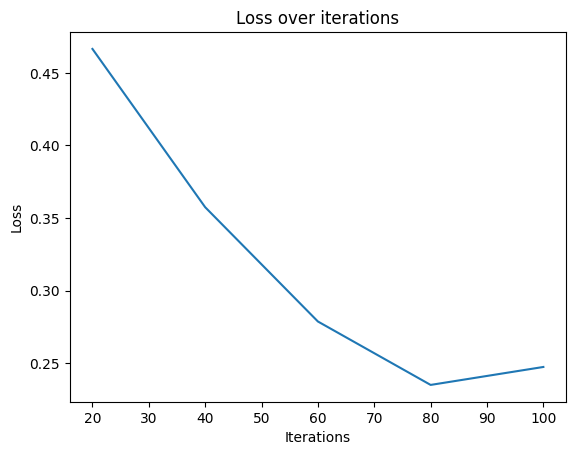

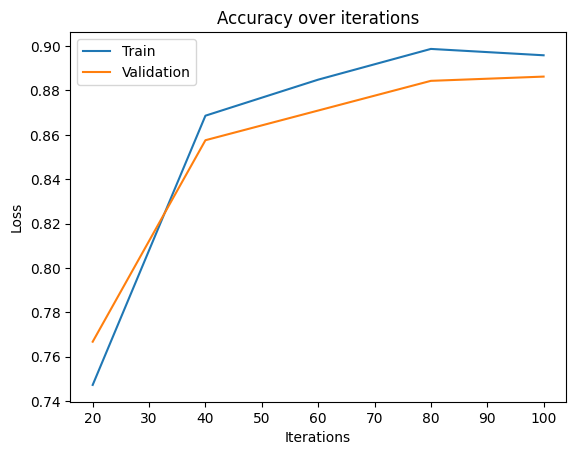

In [ ]:
model_priv = MLPModel()
train_model_private(model_priv, train_dataset, valid_dataset)

**Graded Task**: Plot the histogram of the model prediction for this differentially private model.
How does this histogram differ from that of `model_np` from above?

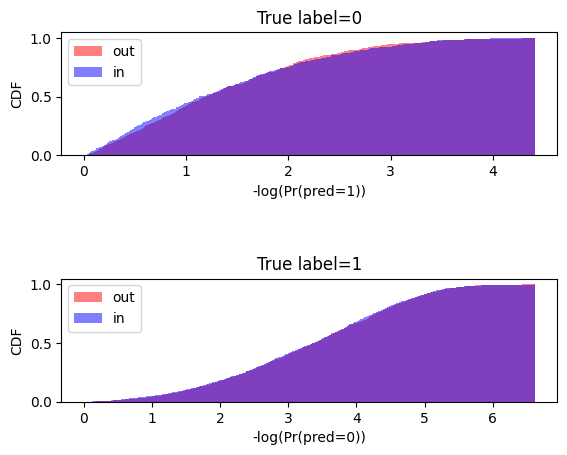

In [ ]:
plot_hist(model_priv, train_dataset, mem_asses_dataset)
plt.close()
# Output given in next panel

*Histogram output:
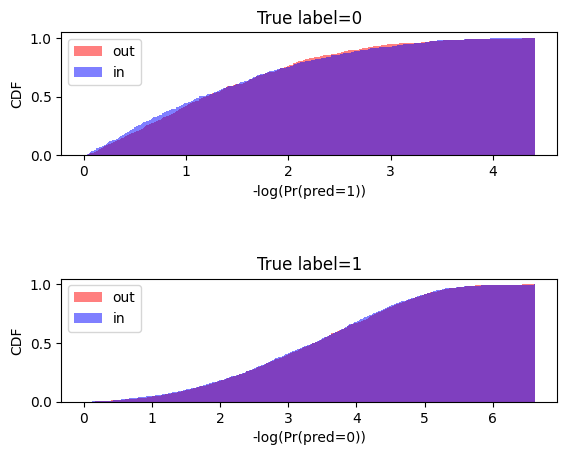

In [ ]:
# There is no protrusion tail going past the train data's histogram by the
# assessment data on the left side, or on the right side, which suggests more
# consistent predictions over both data sets. That is, the model doesn't overfit
# as it has the same distribution of probability judgements for both sets.
# This is in contrast to model_np, which clearly made more skewed incorrect
# predictions on the assessment data set in favour of the training data.

# On the other hand, the overall accuracy on the training data is lower from
# training through DP-SGD, which is a consequence of reducing the information
# with noise and adjusting for the algorithm's normalization techniques. This
# is also a probable cause for why there is no real overfitting, as it avoids
# getting overly used to the training set since the gradients are kept small
# through the clipping and the noise ensures that the data is more homogenous
# and is more varied from the training set.

**Graded Task**: Suppose that an attacker recognizes that your friend Taylor is in this data set, means that their X-ray was taken at some point during a hospitalization,
and that Taylor provided researchers consent to be included in the study dataset. If this information is sold to a third-party (e.g., a credit reporting agency, an employer,
or a landlord), how might this affect Taylor?

In [ ]:
# Attackers can misuse this information to profile Taylor for their choice of
# business to which they sell this information. A credit reporting agency might
# use this knowledge to modify their financial treatment towards Taylor, as a
# health implication would mean higher risk and so increasing insurance premiums
# would be preferred by the agency. This would negatively impact Taylor in her
# finances for no good reason but a breach in personal privacy.

# A landlord instead could deny housing due to health concerns or additional
# complications or paperwork, or even raise prices due to Taylor's need for
# housing when she is in a more vulnerable position due to her hospitalization.
# Likewise, an employer could use this to discriminate her out of a possible
# hiring, since health issues could be viewed as a liability for a company, both
# in terms of health-related leave compensation and possible disabilities that
# would impact work.

# These examples only touch the few predominant ways such information could be
# compromising to Taylor's life and overall security, and suggests why diff.
# privacy is important conduct when training a model on normally personal
# or private data of an individual.

If you are interested in DP, we suggest
performing hyperparameter tuning over batch size and max grad norm.
In, DP-SGD usually larger batch size would help.
So, for instance for two values of $\varepsilon \in \{0.5,1,5\}$,
try to find the best model for $\text{batchsize}\in \{100,500\}$ and $\text{gradnorm}\in\{4,8,16\}$.

## Appendix

- [Differential Privacy and the Census]  https://www.youtube.com/watch?v=nVPE1dbA394
- [Main DP-SGD Paper](https://arxiv.org/abs/1607.00133)
- [CS 860 - Algorithms for Private Data Analysis at UWaterloo](http://www.gautamkamath.com/CS860notes/lec13.pdf)